In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import h5py
import os
from plotting_fxns import *
%load_ext autoreload
%autoreload 2

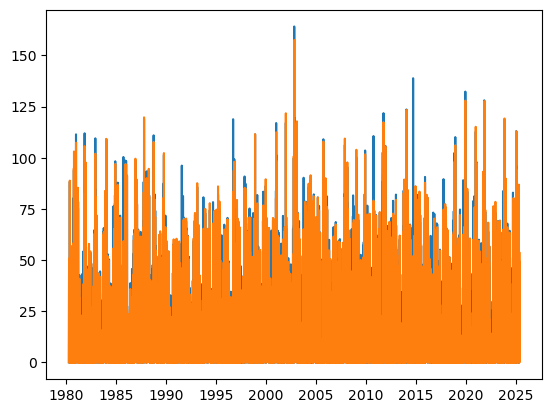

In [5]:
site = 'EC'
glacier = 'wolverine' if site == 'EC' else 'kahiltna' if site == 'KPS' else 'gulkana'

var = 'BDOT'
orig = pd.read_csv(f'../Data/original/{glacier}{site}_1d_forcings.csv',index_col=0)
new = pd.read_csv(f'../Data/{glacier}{site}_1d_forcings.csv',index_col=0)
plt.plot(pd.to_datetime(orig.index), orig[var])
plt.plot(pd.to_datetime(new.index), new[var])
plt.show()

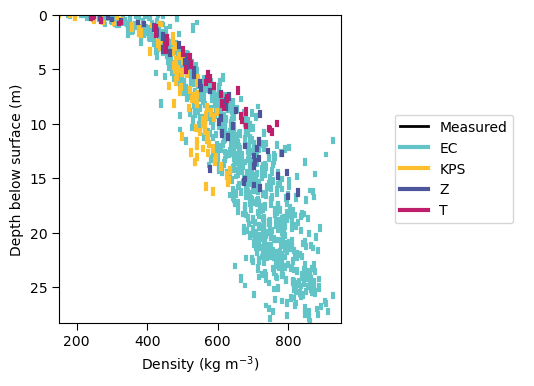

In [39]:
sites = ['EC','KPS','Z','T']
dates = [dates_wolverine_spring,dates_kahiltna_spring,['2025_04_20'],['2025_04_20']]
compare_site_data(sites,dates)

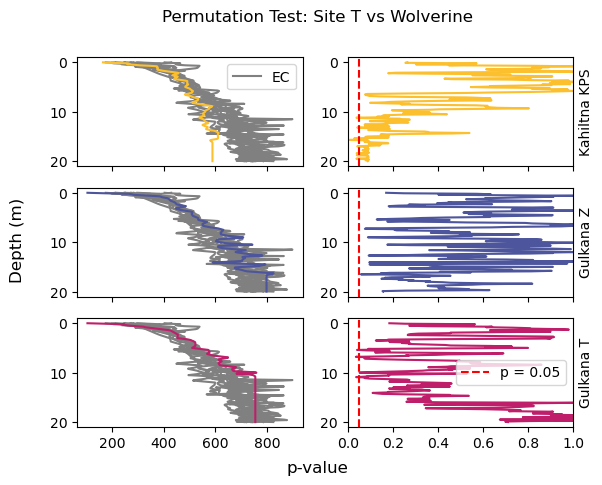

Null hypothesis cannot be rejected at Kahiltna KPS: p = 0.0876
Null hypothesis cannot be rejected at Gulkana Z: p = 0.3514
Null hypothesis cannot be rejected at Gulkana T: p = 0.3475


In [53]:
# Generate density profiles at consistent depths for statistical comparison
depths = np.arange(0, 20.1, 0.1)
date_dict = {'Z':['2025_04_20'],'T':['2025_04_20'],
             'KPS':dates_kahiltna_spring, 'EC':dates_wolverine_spring}
site_cores_interp = {}
for site in ['EC','KPS','Z','T']:
    site_cores_interp[site] = []
    for date in date_dict[site]:
        density_meas, layer_tops, layer_bottoms = get_density_measured(site, date)
        layer_middles = layer_tops + (layer_bottoms - layer_tops) / 2
        density_interp = np.interp(depths, layer_middles, density_meas)
        site_cores_interp[site].append(density_interp)
site_cores_avg = {}
for site in site_cores_interp:
    avg_profile = np.mean(site_cores_interp[site], axis=0)
    site_cores_avg[site] = avg_profile

# Permutation test for each individual depth
plot_permutation_test(site_cores_interp['EC'], site_cores_avg, ['KPS','Z','T'], depths)

# Permutation test for the entire profile
for s,site in enumerate(['KPS','Z','T']):
    glacier = 'Wolverine' if site == 'EC' else 'Kahiltna' if site == 'KPS' else 'Gulkana'
    p_val, _, _ = profile_permutation_test(site_cores_interp['EC'], site_cores_avg[site], n_permutations=10000)
    if p_val <= 0.05:
        print(f'Profiles are significantly different at {glacier} {site}: p = {p_val}')
    else:
        print(f'Null hypothesis cannot be rejected at {glacier} {site}: p = {p_val}')

Mean Absolute Error: 85.6411999518438 kg m-3
Mean Error (Bias): 71.3587195230293 kg m-3


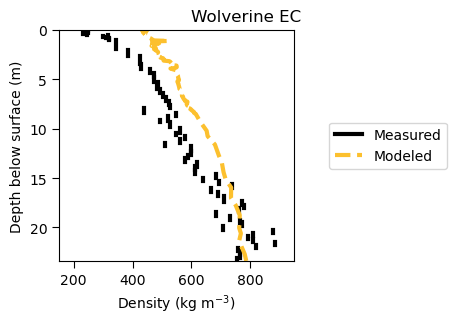

In [42]:
# SIMPLE PLOT
site = 'EC'
rho = 'GSFC2020'
var = 'density'

# measured data
date = dates_wolverine[-1] if site == 'EC' else dates_kahiltna[-1] if site == 'KPS' else '2025_04_20'
density_meas, layer_tops, layer_bottoms = get_density_measured(site, date)

# modeled data
glacier = 'wolverine' if site == 'EC' else 'kahiltna' if site == 'KPS' else 'gulkana'
cfm_fn = f'{glacier}{site}/CFMresults_{glacier}{site}_{rho}_0/CFMresults.hdf5'
density_mod, depth_mod = get_var_modeled(cfm_fn, date, var)

# plot
simple_plot(site, (density_meas, layer_bottoms, layer_tops), (density_mod, depth_mod), print_error=True)

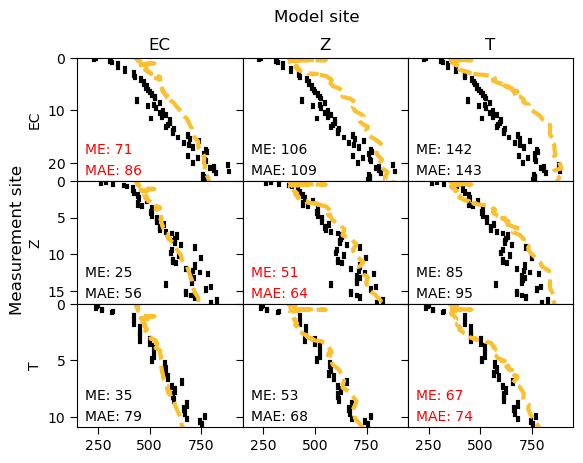

In [15]:
# GET MEASURED DENSITY
site = 'Z'
date = dates_wolverine[-1] if site == 'EC' else dates_kahiltna[-1] if site == 'KPS' else '2025_04_20'
density_meas, layer_tops, layer_bottoms = get_density_measured(site, date)

# plot measurements only
if False:
    plot_density_measured(density_meas, layer_tops, layer_bottoms, site)
    
# GET MODELED DENSITY
rho = 'GSFC2020'
var = 'density'

# specify results file
site = 'EC'
glacier = 'wolverine' if site == 'EC' else 'kahiltna' if site == 'KPS' else 'gulkana'
cfm_fn = f'{glacier}{site}/CFMresults_{glacier}{site}_{rho}_0/CFMresults.hdf5'

# load data
density_mod, depth_mod = get_var_modeled(cfm_fn, date, var)

# plot modeled only
if False:
    fig, ax = plot_var_modeled(density_mod, depth_mod)
    ax.set_title(f'Modeled snow density at {glacier.capitalize()} {site}, {date}')
    ax.set_ylim(max(layer_bottoms), 0)
    plt.show()

# SIMPLE PLOT
fig, axes = plt.subplots(3, 3, gridspec_kw={'hspace':0, 'wspace':0},
                         sharex=True, sharey='row')
for meas,site_meas in enumerate(['EC','Z','T']):
    for mod,site_mod in enumerate(['EC','Z','T']):
        ax = axes[meas, mod]
        # measured data
        date = dates_wolverine[-1] if site_meas == 'EC' else dates_kahiltna[-1] if site_meas == 'KPS' else '2025_04_20'
        density_meas, layer_tops, layer_bottoms = get_density_measured(site_meas, date)

        # modeled data
        glacier = 'wolverine' if site_mod == 'EC' else 'kahiltna' if site_mod == 'KPS' else 'gulkana'
        cfm_fn = f'{glacier}{site_mod}/CFMresults_{glacier}{site_mod}_{rho}_0/CFMresults.hdf5'
        density_mod, depth_mod = get_var_modeled(cfm_fn, date, var)

        # plot
        axes[meas, mod], MAE, ME = simple_plot(site_meas, (density_meas, layer_bottoms, layer_tops), (density_mod, depth_mod), print_error=False,plot_ax=ax)
        # axes[meas, mod].set_title(f'{site_meas} modeled with {site_mod}')
        textc = 'r' if meas == mod else 'k'
        axes[meas, mod].text(0.05, 0.05, f'MAE: {MAE:.0f}',transform=ax.transAxes,color=textc)
        axes[meas, mod].text(0.05, 0.22, f'ME: {ME:.0f}',transform=ax.transAxes,color=textc)
        if mod == 0:
            axes[meas, mod].set_ylabel(site_meas)
        if meas == 0:
            axes[meas, mod].set_title(site_mod)
fig.supylabel('Measurement site')
fig.suptitle('Model site')
plt.show()

In [ ]:
# MODELED DENSITY COMPARISON
# for site in ['Z','EC','T']: # 
#     for rho in ['GSFC2020','Crocus']: 
#         all_measured = []
#         all_modeled = []
#         all_labels = []

#         # specify  results filename
#         glacier = 'wolverine' if site == 'EC' else 'kahiltna' if site == 'KPS' else 'gulkana'
#         const_dict = {'EC':[327, 472], 'Z':[251, 382], 'T':[233, 398]}
#         const_rhos = ['variable'] + const_dict[site]
#         for c,const_rho in zip(['variable','spring','average'], const_rhos):
#             if const_rho == 'variable':
#                 cfm_fn = f'{glacier}{site}/CFMresults_{glacier}{site}_{rho}_wsrho_0/CFMresults.hdf5'
#             else:
#                 cfm_fn = f'{glacier}{site}/CFMresults_{glacier}{site}_{rho}_srho{const_rho}_0/CFMresults.hdf5'

#             # load data
#             date = '2016_05_13' if site == 'EC' else '2025_04_20'
#             density_mod, depth_mod = get_var_modeled(cfm_fn, date, 'density')
#             density_meas, layer_tops, layer_bottoms = get_density_measured(site, date)

#             # get label
#             label = f'Constant {c}' if c != 'variable' else 'PEBSI-derived'

#             all_measured.append((density_meas, layer_bottoms, layer_tops))
#             all_modeled.append((density_mod, depth_mod))
#             all_labels.append(label)

#         # plot
#         simple_comparison(site, all_measured, all_modeled, all_labels, print_error=True,
#                           savefig=f'{glacier}{site}/{glacier}{site}_{rho}_srho_comparison.png',
#                           t=f'{glacier.capitalize()} {site}; {rho}')

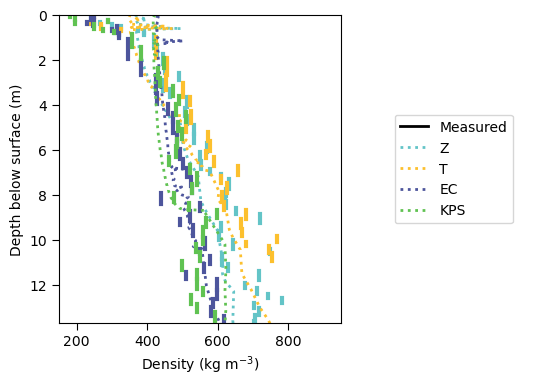

In [ ]:
# GULKANA SIMPLE FIGURE
all_measured = []
all_modeled = []
sites = ['Z','T','EC','KPS']
rho = 'Crocus'
for site in sites:
    # measured
    glacier = 'wolverine' if site == 'EC' else 'kahiltna' if site == 'KPS' else 'gulkana'
    date = dates_wolverine[-1] if site == 'EC' else dates_kahiltna[-1] if site == 'KPS' else '2025_04_20'
    density_meas, layer_tops, layer_bottoms = get_density_measured(site, date)

    # modeled
    cfm_fn_dict = {'Z':f'{glacier}{site}/CFMresults_{glacier}{site}_{rho}_0/CFMresults.hdf5',
                   'T':f'{glacier}{site}/CFMresults_{glacier}{site}_{rho}_0/CFMresults.hdf5',
                   'EC':f'{glacier}{site}/CFMresults_{glacier}{site}_{rho}_0/CFMresults.hdf5',
                   'KPS':f'{glacier}{site}/CFMresults_{glacier}{site}_{rho}_0/CFMresults.hdf5'}
    cfm_fn = cfm_fn_dict[site]
    density_mod, depth_mod = get_var_modeled(cfm_fn, date, 'density')
                                         
    # simple_plot(site, (density_meas, layer_bottoms, layer_tops), (density_mod, depth_mod))
    all_measured.append((density_meas, layer_bottoms, layer_tops))
    all_modeled.append((density_mod, depth_mod))

compare_sites(all_measured, all_modeled, sites)

In [1]:
# WOLVERINE ALL YEARS
site = 'EC'
glacier = 'wolverine' if site == 'EC' else 'kahiltna' if site == 'KPS' else 'gulkana'
data = h5py.File(f'{glacier}{site}/CFMresults_{glacier}{site}_GSFC2020_0/CFMresults.hdf5','r')
# plot_wolverine_years(data, False)
plot_years_together(data, site, False)

NameError: name 'h5py' is not defined

In [ ]:
# COMPARE DENSIFICATION SCHEMES
all_rho = [
            # >> RECOMMENDED BY MAX
            'GSFC2020','Crocus' 
            # >> FUNCTIONAL
            # 'HLdynamic','Arthern2010S','Arthern2010T', 'Barnola1991',
            # 'Ligtenberg2011','Crocus','KuipersMunneke2015','GSFC2020',
            # >> BROKEN
                # 'HLSigfus','Li2011','Helsen2008', 'Ligtenberg2011',
                # 'Arthern2010S','Arthern2010T','Li2015','Goujon2003',
                # 'Barnola1991','Morris2014','KuipersMunneke2015',
]

fn = f'{glacier}{site}/CFMresults_{glacier}{site}_RHO_0/CFMresults.hdf5'
fig, ax = compare_densification(fn, all_rho, date, (density_meas, layer_bottoms, layer_tops))
date_label = date.replace('_','/')
fig.suptitle(f'Site {site} firn core comparison, {date_label}',y=0.97)
plt.show()

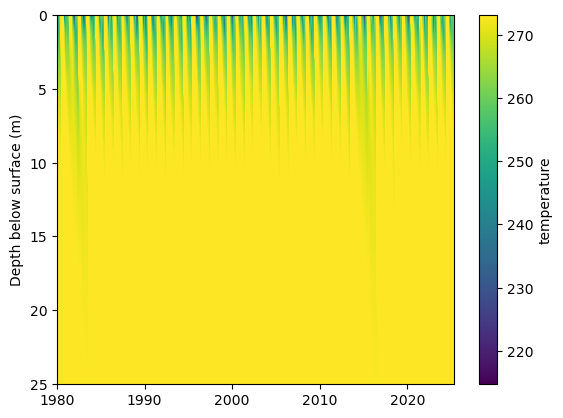

In [43]:
site = 'Z'
glacier = 'wolverine' if site == 'EC' else 'kahiltna' if site == 'KPS' else 'gulkana'
rho = 'GSFC2020'
var = 'temperature'
n_steps = 5
max_depth = 25
output = h5py.File(f'{glacier}{site}/CFMresults_{glacier}{site}_{rho}_0/CFMresults.hdf5')

# find layer tops and bottoms
depth_mod = output['depth'][1:]
max_idx = np.where(depth_mod > max_depth)[0][0]
depth_mod = depth_mod[:max_idx]
layer_tops = np.array(depth_mod)
dz = np.diff(depth_mod)
layer_bottoms = np.append(layer_tops[1:] + dz, np.array([layer_tops[-1] + 0.05]))

# get times and data into the correct format
times = output['density'][1:, 0]
D, T = np.meshgrid(depth_mod, times)
var_data = output[var][1:, 1:max_idx + 1]

# plot
fig, ax = plt.subplots()
c = ax.pcolormesh(T, D, var_data,shading='auto', cmap='viridis')
ax.invert_yaxis()
ax.set_ylabel('Depth below surface (m)')
cb = fig.colorbar(c, ax=ax, label=var)
plt.show()

In [ ]:
# Check energy balance model density performance
# site = 'Z'
# glacier = 'wolverine' if site == 'EC' else 'kahiltna' if site == 'KPS' else 'gulkana'
# ds = xr.open_dataset(f'../../Model/Output/{glacier.capitalize()}_2025_08_28_long{site}_0.nc')
# fig, ax = plt.subplots()
# i = 0
# list_spring = []
# list_fall = []
# for file in os.listdir(f'../Data/cores/{glacier}/'):
#     if site in file:
#         date = file.split(site)[-1][1:].split('.csv')[0]
#         season = 'Spring' if ('_04_' in date or '_05_' in date) else 'Fall'
#         linestyle = '-' # ':' if ('_04_' in date or '_05_' in date) else '-'
#         i = 0 if season == 'Spring' else 1
        
#         # get the modeled density and depth on this date
#         ds_date = ds.sel(time=pd.to_datetime(date.replace('_','/')+' 00:00'))
#         layer_height = ds_date['layerheight'].values
#         dry_density_mod = ds_date['layerdensity'].values
#         water_mod = ds_date['layerwater'].values

#         # calculate actual density considering water content
#         density_mod = (dry_density_mod * layer_height + water_mod) / layer_height
#         depth_mod = np.array([np.sum(layer_height[:i+1])-(layer_height[i]/2) for i in range(len(layer_height))])

#         # get the measured density and depth
#         df = pd.read_csv(f'../Data/cores/{glacier}/' + file)
#         tops = df['SBD'] - df['length']
#         bottoms = df['SBD']
#         edges = np.append(tops.values[0], bottoms)
        
#         # interpolate
#         density_mod_edges = np.interp(edges, depth_mod, density_mod)
#         density_mod_middle = (density_mod_edges[:-1] + density_mod_edges[1:]) / 2
        
#         # compare
#         for top, bottom, mod, meas in zip(tops, bottoms, density_mod_middle, df['density'].values):
#             if bottom <= 2.7:
#                 # ax.plot([mod, mod], [top, bottom], c=colors[i], linestyle=linestyle)
#                 # ax.plot([meas, meas], [top, bottom], c=colors[i], linestyle=linestyle, alpha=0.5)
#                 ax.plot([mod - meas, mod - meas], [top, bottom], c=colors[i], linestyle=linestyle)
#                 if season == 'Spring':
#                     list_spring.append(mod - meas)
#                 else:
#                     list_fall.append(mod - meas)

#         # ax.plot(np.nan, np.nan, c=colors[i], label=date, linestyle=linestyle)
#         i += 1
#         if i >= len(colors):
#             i = 0

# list_spring = np.array(list_spring)
# list_fall = np.array(list_fall)
# print(f'Spring MAE: {np.mean(np.abs(list_spring)):.1f}')
# print(f'Spring Bias: {np.mean(list_spring):.1f}')
# print(f'Fall MAE: {np.mean(np.abs(list_fall)):.1f}')
# print(f'Fall Bias: {np.mean(list_fall):.1f}')

# ax.plot(np.nan, np.nan, c=colors[0],label='Spring')
# ax.plot(np.nan, np.nan, c=colors[1],label='Fall')

# ax.invert_yaxis()
# ax.axvline(0, linewidth=0.5, c='k')
# ax.set_ylim(2.5, 0)
# ax.set_xlim(-400, 400)
# ax.legend()
# ax.set_xlabel('Modeled $-$ Measured Density (kg m$^{-3}$)')
# ax.set_ylabel('Depth below surface (m)')
# ax.set_title(f'Comparison of PEBSI to measured density at {glacier.capitalize()} {site}')
# plt.show()